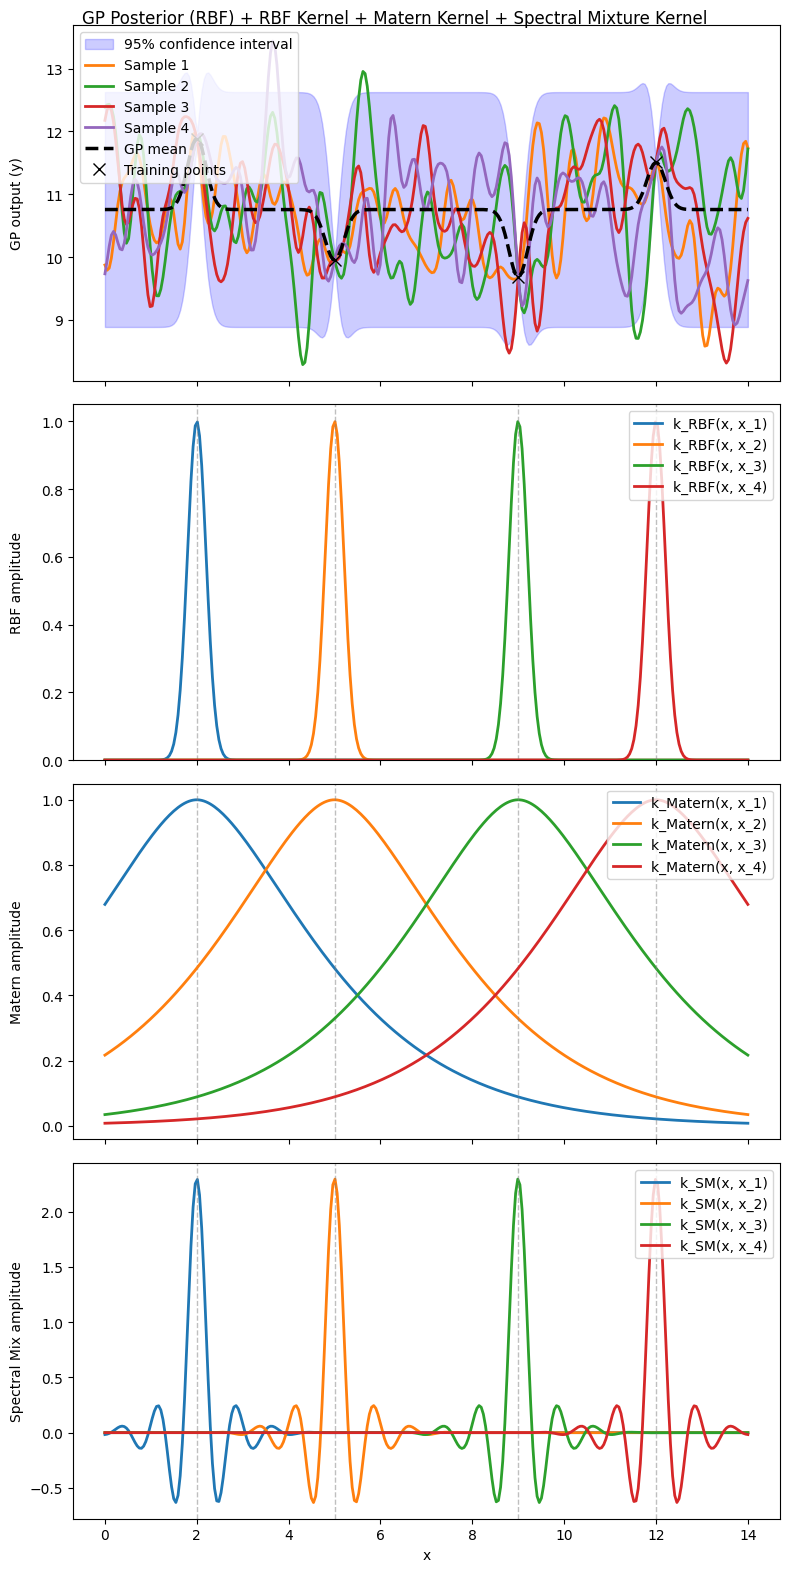

In [6]:
# GaussianProcess_kernel_perspective

# This script demonstrates:
#   - Fitting a Gaussian Process in 1D with an RBF kernel
#   - Plotting posterior mean, sample paths, and confidence intervals
#   - Visualizing different kernels (RBF, Matern, a toy Spectral Mixture) as
#     1D lumps for various training points.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

##############################################################################
# 1) Define a sample function and training data
##############################################################################

def f(x):
    """A smooth function for demonstration."""
    return 10.0 + 0.02 * (x - 8)**2 + 1.2 * np.sin(x / 1.5)

# Sample training points (noise-free)
X_train = np.array([2.0, 5.0, 9.0, 12.0])[:, None]
y_train = f(X_train).ravel()

##############################################################################
# 2) Fit a Gaussian Process with an RBF kernel
##############################################################################

kernel_rbf = RBF(length_scale=3.0)
gp = GaussianProcessRegressor(kernel=kernel_rbf, alpha=0.0, normalize_y=True)
gp.fit(X_train, y_train)

# Define a dense test grid
X_test = np.linspace(0, 14, 300)[:, None]
y_mean, y_std = gp.predict(X_test, return_std=True)

# Draw posterior samples (both train + test => continuous paths)
X_all = np.vstack([X_train, X_test])
y_all_samples = gp.sample_y(X_all, n_samples=4, random_state=None)

##############################################################################
# 3) Helper functions for kernel plotting
##############################################################################

def rbf_1D(x, center, length_scale):
    """RBF = exp(-0.5 * ((x - center)/length_scale)^2)."""
    return np.exp(-0.5 * ((x - center) / length_scale)**2)

def spectral_mixture_kernel_1D(x, center, weights, mus, sigmas):
    """
    Evaluate a 1D spectral mixture kernel with Q components.
    
    k_SM(x, center) = sum_{q=1 to Q} w_q *
                     exp(-2 pi^2 sigma_q^2 (x - center)^2) *
                     cos(2 pi mu_q (x - center))
    """
    diff = x - center
    value = 0.0
    for w, mu, sigma in zip(weights, mus, sigmas):
        gauss_part = np.exp(-2.0 * (np.pi**2) * sigma**2 * diff**2)
        cos_part = np.cos(2.0 * np.pi * mu * diff)
        value += w * gauss_part * cos_part
    return value

##############################################################################
# 4) Create four subplots:
#    1) GP Posterior (RBF)
#    2) RBF kernel lumps
#    3) Matern kernel lumps
#    4) Spectral Mixture kernel lumps
##############################################################################

fig, (ax_top, ax_rbf, ax_matern, ax_smk) = plt.subplots(4, 1, figsize=(8, 16), sharex=True)
fig.suptitle("GP Posterior (RBF) + RBF Kernel + Matern Kernel + Spectral Mixture Kernel")

##############################################################################
# TOP SUBPLOT: GP posterior
##############################################################################

# (a) Confidence band
ax_top.fill_between(
    X_test.ravel(),
    y_mean - 1.96 * y_std,
    y_mean + 1.96 * y_std,
    color='blue',
    alpha=0.2,
    label='95% confidence interval'
)

# (b) 4 posterior sample paths
colors = ['C1', 'C2', 'C3', 'C4']
for i in range(4):
    xy = np.hstack([X_all, y_all_samples[:, i].reshape(-1, 1)])
    xy_sorted = xy[np.argsort(xy[:, 0])]
    
    ax_top.plot(
        xy_sorted[:, 0],
        xy_sorted[:, 1],
        color=colors[i],
        lw=2,
        label=f'Sample {i+1}'
    )

# (c) Posterior mean (dashed black line)
ax_top.plot(
    X_test,
    y_mean,
    'k--',
    lw=2.5,
    label='GP mean'
)

# (d) Training points
ax_top.plot(
    X_train,
    y_train,
    'kx',
    markersize=8,
    label='Training points'
)

ax_top.set_ylabel("GP output (y)")
ax_top.legend(loc='upper left')

##############################################################################
# SECOND SUBPLOT: RBF kernel lumps
##############################################################################

rbf_length_scale = getattr(gp.kernel_, "length_scale", 3.0)

for i, x_c in enumerate(X_train.ravel()):
    k_vals = rbf_1D(X_test.ravel(), x_c, rbf_length_scale)
    ax_rbf.plot(
        X_test,
        k_vals,
        lw=2,
        label=f"k_RBF(x, x_{i+1})"
    )
    ax_rbf.axvline(x_c, color='gray', lw=1, ls='--', alpha=0.5)

ax_rbf.set_ylabel("RBF amplitude")
ax_rbf.set_ylim([0, 1.05])
ax_rbf.legend(loc='upper right')

##############################################################################
# THIRD SUBPLOT: Matern kernel lumps
##############################################################################

matern_kernel = Matern(length_scale=3.0, nu=1.5)

for i, x_c in enumerate(X_train.ravel()):
    # Evaluate Matern kernel at all X_test points
    matern_vals = np.array([
        matern_kernel([[xt]], [[x_c]])[0, 0]
        for xt in X_test.ravel()
    ])
    
    ax_matern.plot(
        X_test,
        matern_vals,
        lw=2,
        label=f"k_Matern(x, x_{i+1})"
    )
    ax_matern.axvline(x_c, color='gray', lw=1, ls='--', alpha=0.5)

ax_matern.set_ylabel("Matern amplitude")
ax_matern.legend(loc='upper right')

##############################################################################
# FOURTH SUBPLOT: Spectral Mixture kernel lumps
##############################################################################

# A toy example with 3 mixture components
weights = [1.0, 0.8, 0.5]
mus     = [0.3, 0.8, 1.2]
sigmas  = [0.8, 0.4, 0.2]

for i, x_c in enumerate(X_train.ravel()):
    sm_vals = np.array([
        spectral_mixture_kernel_1D(xt, x_c, weights, mus, sigmas)
        for xt in X_test.ravel()
    ])
    
    ax_smk.plot(
        X_test,
        sm_vals,
        lw=2,
        label=f"k_SM(x, x_{i+1})"
    )
    ax_smk.axvline(x_c, color='gray', lw=1, ls='--', alpha=0.5)

ax_smk.set_xlabel("x")
ax_smk.set_ylabel("Spectral Mix amplitude")
ax_smk.legend(loc='upper right')

##############################################################################
# Align y-labels and show
##############################################################################
plt.tight_layout()
fig.align_ylabels()
plt.show()
